# Importar librerias

In [2]:
# Para cargar y manipular datos en dataframes.
import pandas as pd
# Para crear combinaciones del grid de hiperparámetros.
import itertools
# Librería principal de PyTorch para manejar tensores.
import torch
# Para construir redes neuronales 
from torch import nn
# Para crear datasets y dataloaders de PyTorch.
from torch.utils.data import Dataset, DataLoader
# Para reducir dimensionalidad de tus features antes de entrenar.
from sklearn.decomposition import PCA
# Para dividir el dataset en train/validation/test.
from sklearn.model_selection import train_test_split
# Para escalar los datos usando media y desviación estándar.
from sklearn.preprocessing import StandardScaler
# Para convertir clases categóricas en enteros.
from sklearn.preprocessing import LabelEncoder
# Para evaluar el desempeño del modelo (métricas de clasificación).
from sklearn.metrics import f1_score
# Para generar la matriz de confusión.
from sklearn.metrics import confusion_matrix
# Para crear visualizaciones básicas como curvas y matrices.
import matplotlib.pyplot as plt
# Para visualizaciones  (heatmaps, etc.).
import seaborn as sns
# Operaciones matemáticas y manejo de arrays.
import numpy as np
# Para convertir etiquetas en formato binario (ROC multiclase).
from sklearn.preprocessing import label_binarize
# Para calcular curvas ROC.
from sklearn.metrics import roc_curve
# Para calcular área bajo la curva ROC.
from sklearn.metrics import auc as sklearn_auc
# Para optimizadores de PyTorch (Adam, SGD, etc.).
import torch.optim as optim
# métricas adicionales: precisión, recall, MCC y AUC multiclase.
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef, roc_auc_score
# copy: para hacer copias profundas (guardar el mejor modelo sin modificarlo).
import copy


# Manejo de datos

## 1. De CSV a DataFrame

In [3]:
# Cargar y evaluar la dimensionalidad de los datos

df_data = pd.read_csv('data.csv').drop(columns=["Unnamed: 0"])
df_labels = pd.read_csv('labels.csv')
print("Dimensionalidad de datos:", df_data.shape)
print("Dimensionalidad de datos:", df_labels.shape)
print("Categorías verdaderas únicas:", df_labels.Class.unique())

df_data.head()

X = df_data.values
y = df_labels["Class"].values

Dimensionalidad de datos: (801, 20531)
Dimensionalidad de datos: (801, 2)
Categorías verdaderas únicas: ['PRAD' 'LUAD' 'BRCA' 'KIRC' 'COAD']


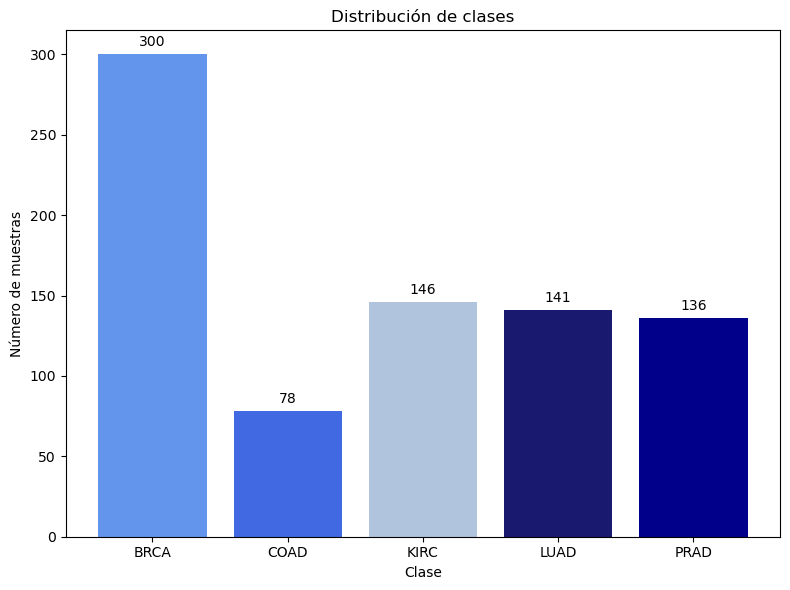

In [4]:
classes, counts = np.unique(df_labels["Class"], return_counts=True)

plt.figure(figsize=(8,6))
plt.bar(classes, counts, color=['cornflowerblue','royalblue','lightsteelblue','midnightblue','darkblue'])

plt.xlabel('Clase')
plt.ylabel('Número de muestras')
plt.title("Distribución de clases")

for i, count in enumerate(counts):
    plt.text(i, count + 5, str(count), ha='center')

plt.tight_layout()
plt.show()


## 2. Separación de datos en entrenamiento y prueba

In [5]:
# Primero train/test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Partimos train en train/validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(512, 20531)
(512,)
(161, 20531)
(161,)


/tmp/ipykernel_1931534/515340654.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, ax=axes[0], palette="Blues")
/tmp/ipykernel_1931534/515340654.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_val, ax=axes[1], palette="Blues")
/tmp/ipykernel_1931534/515340654.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, ax=axes[2], palette="Blues")


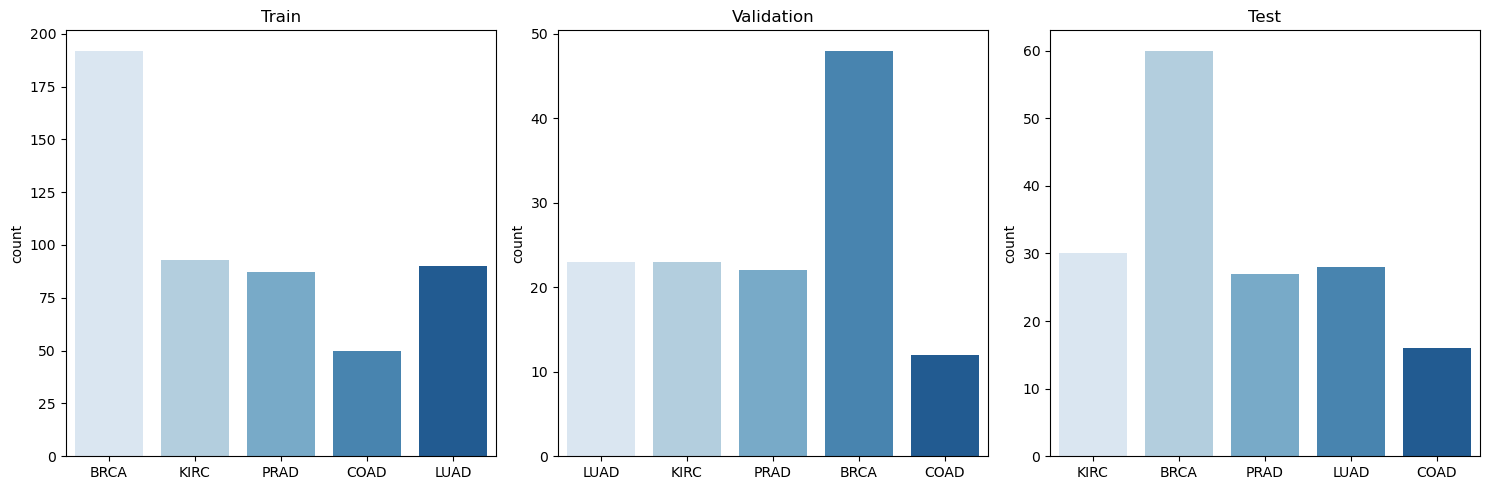

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.countplot(x=y_train, ax=axes[0], palette="Blues")
axes[0].set_title("Train")

sns.countplot(x=y_val, ax=axes[1], palette="Blues")
axes[1].set_title("Validation")

sns.countplot(x=y_test, ax=axes[2], palette="Blues")
axes[2].set_title("Test")

plt.tight_layout()
plt.show()


Se observa la misma proporción en la separación de los datos para Train, Validation y Test 

## Escalamiento y reducción de dimensionalidad 

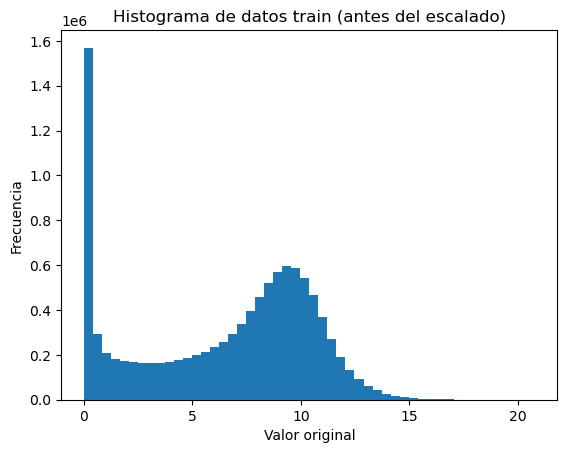

In [7]:
plt.hist(X_train.flatten(), bins=50)
plt.title("Histograma de datos train (antes del escalado)")
plt.xlabel("Valor original")
plt.ylabel("Frecuencia")
plt.show()

In [8]:
# Escalando solo con TRAIN

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

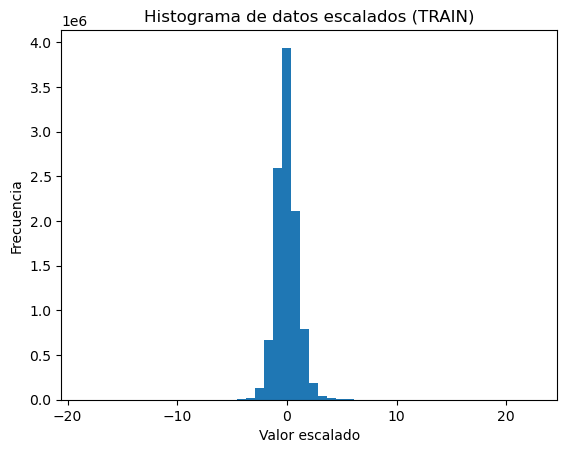

In [9]:
import matplotlib.pyplot as plt

plt.hist(X_train_scaled.flatten(), bins=50)
plt.title("Histograma de datos escalados (TRAIN)")
plt.xlabel("Valor escalado")
plt.ylabel("Frecuencia")
plt.show()


In [10]:
# PCA solo con TRAIN

pca = PCA(n_components=200, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca   = pca.transform(X_val_scaled)
X_test_pca  = pca.transform(X_test_scaled)

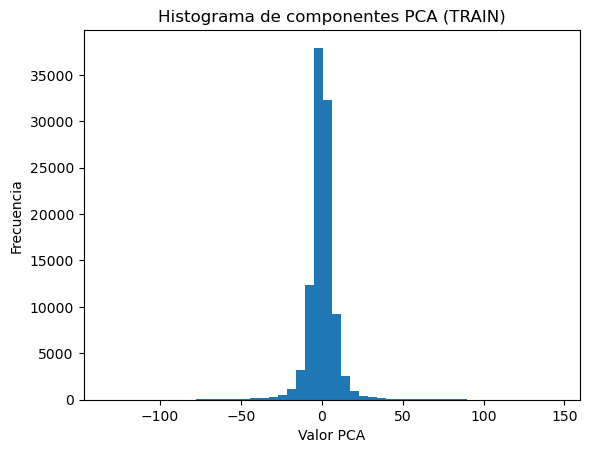

In [11]:
plt.hist(X_train_pca.flatten(), bins=50)
plt.title("Histograma de componentes PCA (TRAIN)")
plt.xlabel("Valor PCA")
plt.ylabel("Frecuencia")
plt.show()


El PCA está capturando variabilidad agregada

## Codificar los Labels 

In [12]:
# Labels codificados

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)


## 3. De Pandas DataFrame a PyTorch DataSet

In [13]:
class PerfilesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = PerfilesDataset(X_train_pca, y_train_enc)
val_dataset   = PerfilesDataset(X_val_pca, y_val_enc)
test_dataset  = PerfilesDataset(X_test_pca, y_test_enc)


# Definición de `device` para entrenamiento

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device disponible para entrenamiento:", device)

Device disponible para entrenamiento: cpu


# Diseño de la arquitectura de la red neuronal

In [15]:
# En mi caso serían 200 neuronas de entrada porque es la cantidad de genes que tiene mi dataLoader 
# y 5 neuronas de salida porque ese es el npumero de categorías que tengo 
# 128 nodos 
# según la literatura se recomienda la siguente estructura: 

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.capas = nn.Sequential(
            nn.Linear(200, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )
    def forward(self, x):
        return self.capas(x)

# Entrenamiento y validación con Grid 

## Hiper parámetros 

In [16]:
batch_sizes = [8, 16, 32, 64]
learning_rates = [1e-3, 1e-5, 3e-5]
epochs_list = [6, 10, 20, 40, 100]

## Busqueda con el grid 

In [17]:
param_grid = list(itertools.product(batch_sizes, learning_rates, epochs_list))

results = []

best_model_state = None
best_params = None
best_val_f1 = -1

criterion = nn.CrossEntropyLoss()

for batch_size, lr, num_epochs in param_grid:

    print(f"\nProbando BS={batch_size}, LR={lr}, EP={num_epochs}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = MLP().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)


    # Entrenamiento ######################
    for epoch in range(num_epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

   
    # Métricas de entrenamiento ###########
    model.eval()
    train_losses, train_preds, train_labels = [], [], []

    with torch.no_grad():
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            train_losses.append(loss.item())

            pred = torch.argmax(logits, 1).cpu().numpy()
            train_preds.extend(pred)
            train_labels.extend(yb.cpu().numpy())

    train_f1 = f1_score(train_labels, train_preds, average="weighted")
    train_loss = np.mean(train_losses)

    
    # Metricas de validacion ###########################
    val_losses, val_preds, val_labels = [], [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_losses.append(loss.item())

            pred = torch.argmax(logits, 1).cpu().numpy()
            val_preds.extend(pred)
            val_labels.extend(yb.cpu().numpy())

    val_f1 = f1_score(val_labels, val_preds, average="weighted")
    val_loss = np.mean(val_losses)

    
    # Detectar sobre ajuste ###############

    gap_f1 = train_f1 - val_f1
    gap_loss = val_loss - train_loss

    overfit = (gap_f1 > 0.10) and (gap_loss > 0.10)

    
    # Guardar resultados del grid ###################
    results.append({
        "batch_size": batch_size,
        "learning_rate": lr,
        "epochs": num_epochs,
        "Train_F1": train_f1,
        "Val_F1": val_f1,
        "Train_Loss": train_loss,
        "Val_Loss": val_loss,
        "Overfitting": overfit
    })

    
    # Elegir mejor modelo ##################
    if (not overfit) and (val_f1 > best_val_f1):
        best_val_f1 = val_f1
        best_model_state = copy.deepcopy(model.state_dict())
        best_params = (batch_size, lr, num_epochs)

torch.save(best_model_state, "mejor_modelo_mlp_3.mod")


# Guardar tabla de resultados del grid 

df_results = pd.DataFrame(results)
df_results.to_csv("metricas_grid_mlp.csv", index=False)
print(df_results)



Probando BS=8, LR=0.001, EP=6



Probando BS=8, LR=0.001, EP=10

Probando BS=8, LR=0.001, EP=20

Probando BS=8, LR=0.001, EP=40

Probando BS=8, LR=0.001, EP=100

Probando BS=8, LR=1e-05, EP=6

Probando BS=8, LR=1e-05, EP=10

Probando BS=8, LR=1e-05, EP=20

Probando BS=8, LR=1e-05, EP=40

Probando BS=8, LR=1e-05, EP=100

Probando BS=8, LR=3e-05, EP=6

Probando BS=8, LR=3e-05, EP=10

Probando BS=8, LR=3e-05, EP=20

Probando BS=8, LR=3e-05, EP=40

Probando BS=8, LR=3e-05, EP=100

Probando BS=16, LR=0.001, EP=6

Probando BS=16, LR=0.001, EP=10

Probando BS=16, LR=0.001, EP=20

Probando BS=16, LR=0.001, EP=40

Probando BS=16, LR=0.001, EP=100

Probando BS=16, LR=1e-05, EP=6

Probando BS=16, LR=1e-05, EP=10

Probando BS=16, LR=1e-05, EP=20

Probando BS=16, LR=1e-05, EP=40

Probando BS=16, LR=1e-05, EP=100

Probando BS=16, LR=3e-05, EP=6

Probando BS=16, LR=3e-05, EP=10

Probando BS=16, LR=3e-05, EP=20

Probando BS=16, LR=3e-05, EP=40

Probando BS=16, LR=3e-05, EP=100

Probando BS=32, LR=0.001, EP=6

Probando BS=32, LR=0.00

## Evaluación con TEST 

In [18]:
best_model = MLP().to(device)
best_model.load_state_dict(best_model_state)
best_model.eval()

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_preds, test_labels, test_losses = [], [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = best_model(xb)
        loss = criterion(logits, yb)

        test_losses.append(loss.item())
        pred = torch.argmax(logits, 1).cpu().numpy()
        test_preds.extend(pred)
        test_labels.extend(yb.cpu().numpy())

test_f1 = f1_score(test_labels, test_preds, average="weighted")
test_precision = precision_score(test_labels, test_preds, average="weighted")
test_recall = recall_score(test_labels, test_preds, average="weighted")
test_mcc = matthews_corrcoef(test_labels, test_preds)

df_test = pd.DataFrame([{
    "Best_batch_size": best_params[0],
    "Best_lr": best_params[1],
    "Best_epochs": best_params[2],
    "Test_F1": test_f1,
    "Test_Precision": test_precision,
    "Test_Recall": test_recall,
    "Test_MCC": test_mcc
}])

df_test.to_csv("metricas_finales_test_mlp.csv", index=False)
df_test


,Best_batch_size,Best_lr,Best_epochs,Test_F1,Test_Precision,Test_Recall,Test_MCC
0,8,0.001,6,0.993758,0.993891,0.993789,0.991846


In [19]:
print(df_test)

   Best_batch_size  Best_lr  Best_epochs   Test_F1  Test_Precision  \
0                8    0.001            6  0.993758        0.993891   

   Test_Recall  Test_MCC  
0     0.993789  0.991846  


# Gráficas del mejor modelo 

In [20]:
# Cargar el mejor modelo 

best_model = MLP().to(device)
best_model.load_state_dict(torch.load("mejor_modelo_mlp_3.mod"))
best_model.eval()

/tmp/ipykernel_1931534/2089080793.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("mejor_modelo_mlp_3.mod"))


MLP(
  (capas): Sequential(
    (0): Linear(in_features=200, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=5, bias=True)
  )
)

## Matriz de confusión 

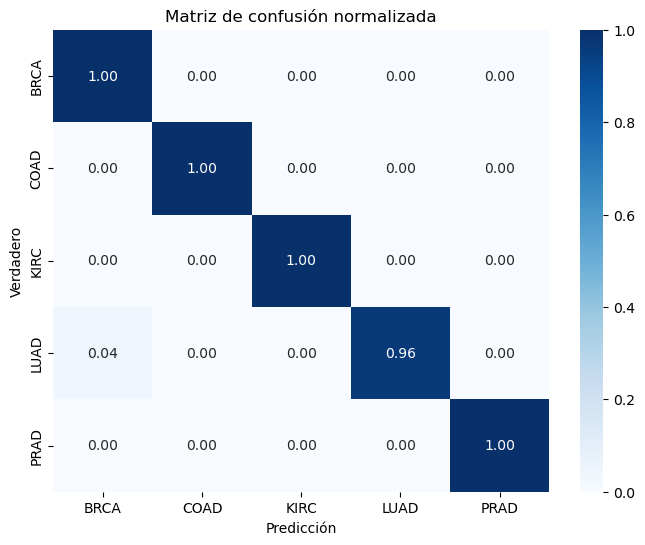

<Figure size 640x480 with 0 Axes>

In [21]:
# Obtener nombres de las clases en el orden correcto
class_names = le.classes_

# Predicciones
all_logits = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in DataLoader(test_dataset, batch_size=32, shuffle=False):
        batch_x = batch_x.to(device)

        logits = best_model(batch_x)           
        all_logits.append(logits.cpu().numpy())
        all_labels.extend(batch_y.numpy())

all_logits = np.vstack(all_logits)
all_labels = np.array(all_labels)

preds = np.argmax(all_logits, axis=1)
probs = torch.softmax(torch.tensor(all_logits), dim=1).numpy()

# Matriz de confusión normalizada
cm = confusion_matrix(all_labels, preds, normalize="true")

plt.figure(figsize=(8,6))
sns.heatmap(
    cm, annot=True, fmt=".2f", cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.title("Matriz de confusión normalizada")
plt.show()

plt.savefig("MatrizConfusion_norm_mejormodelo_mlp.png")


## Gráfica de la curva ROC

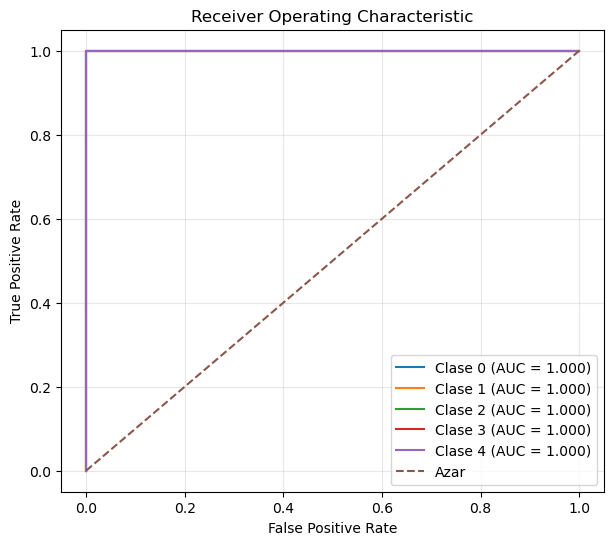

<Figure size 640x480 with 0 Axes>

In [24]:
num_classes = len(np.unique(all_labels))

y_bin = label_binarize(all_labels, classes=list(range(num_classes)))

plt.figure(figsize=(7, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
    roc_auc = sklearn_auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Clase {i} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", label="Azar")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
plt.savefig('AUCROC_mejor_modelo_mlp.png') 


# Usar mejor modelo entrenado


In [ ]:
def predict(dataloader, modelo):
    modelo.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            logits = modelo(X)

            # predicción (entero)
            pred = logits.argmax(1).item()

            # verdadero (entero)
            true = y.item()

            print(f"Logits: {logits}")
            print(f"Predicción (entero): {pred}")
            print(f"Verdadero (entero): {true}")
            print("------------------------------")


In [ ]:
mejor_modelo = MLP().to(device)
mejor_modelo.load_state_dict(torch.load("mejor_modelo_mlp_3.mod"))
mejor_modelo.eval()

/tmp/ipykernel_1903274/1227759051.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mejor_modelo.load_state_dict(torch.load("mejor_modelo_mlp_3.mod"))


MLP(
  (capas): Sequential(
    (0): Linear(in_features=200, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=5, bias=True)
  )
)

In [ ]:
dataset_test = PerfilesDataset(X_test_pca, y_test_enc)
dataloader_predict = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [ ]:
predict(dataloader_predict, mejor_modelo)

Logits: tensor([[-1.9260, -1.1401,  2.9570, -1.6282, -1.0720]])
Predicción (entero): 2
Verdadero (entero): 2
------------------------------
Logits: tensor([[ 8.2240, -3.6027, -1.7062, -1.0045, -2.6249]])
Predicción (entero): 0
Verdadero (entero): 0
------------------------------
Logits: tensor([[ 7.0366, -2.8585, -2.7199, -1.2331, -3.7173]])
Predicción (entero): 0
Verdadero (entero): 0
------------------------------
Logits: tensor([[-4.5988, -4.6292, -5.0179, -4.0474,  8.7730]])
Predicción (entero): 4
Verdadero (entero): 4
------------------------------
Logits: tensor([[-1.7366, -3.9135,  9.4107, -1.4238, -5.7239]])
Predicción (entero): 2
Verdadero (entero): 2
------------------------------
Logits: tensor([[-0.4925, -3.1789,  7.0278,  0.6192, -5.5243]])
Predicción (entero): 2
Verdadero (entero): 2
------------------------------
Logits: tensor([[-0.6504, -3.9009,  7.1594, -1.1362, -3.8473]])
Predicción (entero): 2
Verdadero (entero): 2
------------------------------
Logits: tensor([[ 6.